In [10]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [11]:
files = glob.glob("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_3_2019_run_corr_15min/*.csv")
file_len = len(files)

# Create functions to process & build csv files in a format of concatted dataframe:

- Specifically for the format of file name: e.g. a9000_d.csv

- Specially for the downloaded data files from TB

In [12]:
def read_and_add_tickers(file):
    df = pd.read_csv(file, header=None, sep = ',')
    ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
    df['ticker'] = ticker
    return df

# all_csv_files format example:"C:/Users/12_28_commodities_daily/*.csv"
def concat_files_inside_folders(all_csv_files):
    files = glob.glob(all_csv_files)
    dfs = [read_and_add_tickers(file) for file in files]
    futuresdata = pd.concat(dfs,ignore_index=True)
    futuresdata.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'holdings', 'ticker']
    return futuresdata

In [13]:
# Test the function:
data = concat_files_inside_folders("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_3_2019_run_corr_15min/*.csv")

In [14]:
data.tail()

,date,open,high,low,close,volume,holdings,ticker
489786,2019/01/03 13:45,2140.0,2142.0,2138.0,2141.0,13718,577670,RM000
489787,2019/01/03 14:00,2141.0,2145.0,2141.0,2143.0,17758,578062,RM000
489788,2019/01/03 14:15,2143.0,2143.0,2139.0,2140.0,17758,576928,RM000
489789,2019/01/03 14:30,2140.0,2143.0,2140.0,2142.0,15546,574754,RM000
489790,2019/01/03 14:45,2142.0,2144.0,2141.0,2142.0,23370,562806,RM000


In [15]:
len(data)

489791

# Create functions to generate statistical analyses for all tickers' data

This part is based on the dataframe we have generated from Step One.

## Correlation Heatmap

In [16]:
data_ = data[['date', 'close', 'ticker']]
data_.head(3)

,date,close,ticker
0,2012/05/10 09:00,6163.0,ag000
1,2012/05/10 09:15,6160.0,ag000
2,2012/05/10 09:30,6149.0,ag000


In [17]:
# Generate a ticker list for later use.
def create_ticker_list(all_csv_files):
    ticker_list = []
    files = glob.glob(all_csv_files)
    for file in files:
        ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
        ticker_list.append(ticker)
    return ticker_list

ticker_list = create_ticker_list("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_3_2019_run_corr_15min/*.csv")

In [18]:
# Create a new column for the percentage change of each ticker's close price
data_['pct_chg'] = data_.groupby(['ticker'])['close'].apply(lambda x: x.pct_change())

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# Check if the first pct_chg for each ticker is NaN, if so, then good to proceed.
print (data_[data_['ticker']=='ag000'].head(3))
print (data_[data_['ticker']=='cu000'].head(3))

               date   close ticker   pct_chg
0  2012/05/10 09:00  6163.0  ag000       NaN
1  2012/05/10 09:15  6160.0  ag000 -0.000487
2  2012/05/10 09:30  6149.0  ag000 -0.001786
                    date    close ticker   pct_chg
188080  2006/01/26 11:15  45125.0  cu000       NaN
188081  2006/01/26 13:30  45144.0  cu000  0.000421
188082  2006/01/26 13:45  45252.0  cu000  0.002392


In [24]:
# create a ticker_dfs as a data table list, separated by tickers, for later merging's purpose.
def choose_df_on_tickers(ticker, main_df):
    ticker_df = main_df[main_df['ticker']==ticker]
    return ticker_df

ticker_dfs = [choose_df_on_tickers(ticker, data_) for ticker in ticker_list]

In [27]:
# Trim each ticker's data table's columns to only date and pct_chg
# And then change the pct_chg column name to each ticker's name for later correlation plotting's purpose
def choose_pct_col_df(ticker_df):
    ticker_col = ticker_df['ticker'].values[1]
    ticker_df_trimmed = ticker_df[['date', 'pct_chg']]
    ticker_df_trimmed.columns = ['date', ticker_col]
    return ticker_df_trimmed

# ticker_df_trimmed is still a list including all tickers' data tables
ticker_df_trimmed = [choose_pct_col_df(ticker_df) for ticker_df in ticker_dfs]

In [28]:
# Create the first merged dataframe using the first two tickers' data
merged = ticker_df_trimmed[0].merge(ticker_df_trimmed[1], on = 'date', how='outer')

In [29]:
merged.head(2)

,date,ag000,al000
0,2012/05/10 09:00,NaN,-0.00062
1,2012/05/10 09:15,-0.000487,-0.00031


In [30]:
# Check each ticker data's date range:
def check_dt_range(ticker_list, ticker_df_trimmed):
    for i in range(0, len(ticker_list)+1):
        try: 
            print ('------------------------')
            print ("ticker {}: ".format(i+1), ticker_df_trimmed[i].columns[1])
            print ("start_date", ticker_df_trimmed[i]['date'].values[0])
            print ("end_date", ticker_df_trimmed[i]['date'].values[-1])
        except IndexError:
            print ("Hit the last one. Done")
            
check_dt_range(ticker_list, ticker_df_trimmed)

------------------------
ticker 1:  ag000
start_date 2012/05/10 09:00
end_date 2019/01/03 14:45
------------------------
ticker 2:  al000
start_date 2006/01/26 14:45
end_date 2019/01/03 14:45
------------------------
ticker 3:  au000
start_date 2008/01/09 09:00
end_date 2019/01/03 14:45
------------------------
ticker 4:  cu000
start_date 2006/01/26 11:15
end_date 2019/01/03 14:45
------------------------
ticker 5:  hc000
start_date 2014/03/21 09:00
end_date 2019/01/03 14:45
------------------------
ticker 6:  j9000
start_date 2011/04/15 09:00
end_date 2019/01/03 14:45
------------------------
ticker 7:  jm000
start_date 2013/03/22 09:00
end_date 2019/01/03 14:45
------------------------
ticker 8:  m9000
start_date 2006/01/27 14:15
end_date 2019/01/03 14:45
------------------------
ticker 9:  rb000
start_date 2009/03/27 09:00
end_date 2019/01/03 14:45
------------------------
ticker 10:  RM000
start_date 2012/12/28 09:00
end_date 2019/01/03 14:45
------------------------
Hit the last o

In [31]:
def merge_the_rest(ticker_list, merged, ticker_df_trimmed):
    for i in range(2, len(ticker_list)):
        merged = merged.merge(ticker_df_trimmed[i], on = 'date', how='outer')
        all_merged = merged.copy()
    return all_merged

all_merged = merge_the_rest(ticker_list, merged, ticker_df_trimmed)

In [32]:
all_merged.sort_values('date', inplace=True)

In [33]:
all_merged.tail()

,date,ag000,al000,au000,cu000,hc000,j9000,jm000,m9000,rb000,RM000
53012,2019/01/03 13:45,0.000533,0.000747,0.000172,0.001692,0.003318,0.002874,0.000423,0.001495,0.001763,0.000935
53013,2019/01/03 14:00,-0.000800,-0.000373,-0.000345,0.000000,0.000000,0.000781,-0.000423,-0.001119,0.001760,0.000934
53014,2019/01/03 14:15,0.003734,-0.000373,0.000862,0.001056,0.005412,0.005726,0.003386,-0.001121,0.003220,-0.001400
53015,2019/01/03 14:30,0.000000,-0.002988,0.000172,-0.002742,-0.001196,0.000776,-0.000844,0.000748,0.000584,0.000935
53016,2019/01/03 14:45,0.000266,0.000375,0.000689,0.001058,-0.000898,0.000259,0.004643,0.000747,0.000583,0.000000


In [34]:
corr_matrix = all_merged[all_merged.columns[1:]].corr()

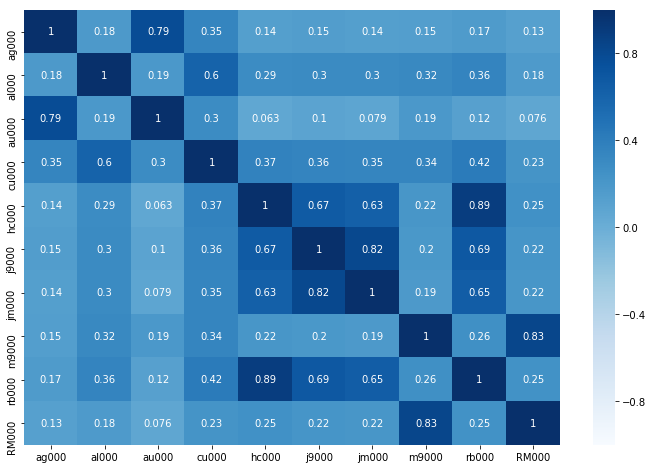

In [38]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(corr_matrix, ax = ax, cmap = 'Blues', vmax = 1.0, vmin = -1.0, annot=True)